<a href="https://colab.research.google.com/github/sanjulikasharma/Acmegrade_Projects/blob/main/Vision_Transformers_using_Computer_Vision_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import OxfordIIITPet

In [2]:
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the Oxford-IIIT Pet dataset
trainset = OxfordIIITPet(root='./data', split='trainval', target_types='category', download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = OxfordIIITPet(root='./data', split='test', target_types='category', download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 792M/792M [00:21<00:00, 36.2MB/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:01<00:00, 14.3MB/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embed_dim=256):
        super(PatchEmbedding, self).__init__()
        self.embedding = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.embedding(x)
        return x.flatten(2).transpose(1, 2)  # Flatten and transpose patches


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(nn.Linear(embed_dim, embed_dim * 4), nn.ReLU(), nn.Linear(embed_dim * 4, embed_dim))
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, x):
        attention = self.attention(x, x, x)[0]
        x = self.norm1(attention + x)
        x = x + self.ffn(x)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, num_classes, embed_dim=256, num_heads=8, num_blocks=6):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(embed_dim=embed_dim)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(embed_dim, num_heads) for _ in range(num_blocks)])
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer_blocks(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

In [4]:
# Hyperparameters
num_classes = 37  # Oxford-IIIT Pet has 37 classes
learning_rate = 0.001
num_epochs = 10

# Initialize model, loss function, and optimizer
model = VisionTransformer(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}')

Epoch [1/10], Loss: 3.7433
Epoch [2/10], Loss: 3.6782
Epoch [3/10], Loss: 3.6618
Epoch [4/10], Loss: 3.6560
Epoch [5/10], Loss: 3.6557
Epoch [6/10], Loss: 3.6497
Epoch [7/10], Loss: 3.6462
Epoch [8/10], Loss: 3.6379
Epoch [9/10], Loss: 3.6398
Epoch [10/10], Loss: 3.6415


In [5]:
# Evaluation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test images: {100 * correct / total:.2f}%')

Accuracy on test images: 2.67%


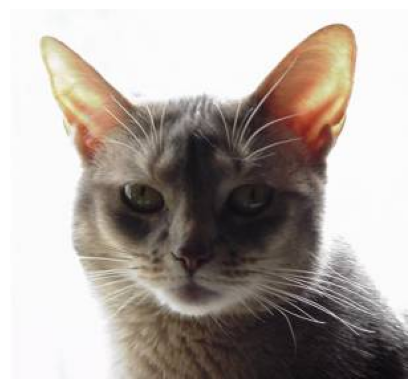

Predicted class: Abyssinian


In [10]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image and display it
image_path = '/content/data/oxford-iiit-pet/images/Abyssinian_206.jpg'  # Replace with the actual image path
image = Image.open(image_path).convert('RGB')

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

# Predict the class
class_names = trainset.classes  # Get class names from the dataset
predicted_class = predict_image(model, image_path, transform, class_names)
print(f'Predicted class: {predicted_class}')
